In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision

In [2]:
dataset = torchvision.datasets.MNIST('./data', train=True, download=True)

train_set = torch.utils.data.Subset(dataset, torch.arange(0,45000))
validation_set = torch.utils.data.Subset(dataset, torch.arange(45000,50000))
test_set = torch.utils.data.Subset(dataset, torch.arange(50000,len(dataset)))

bsize = 64

train_dataloader = data_utils.DataLoader(train_set, batch_size = bsize, sampler=data_utils.RandomSampler)
validation_set = data_utils.DataLoader(validation_set, batch_size = bsize, sampler=data_utils.RandomSampler)
test_set = data_utils.DataLoader(test_set, batch_size = bsize, sampler=data_utils.SequentialSampler)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



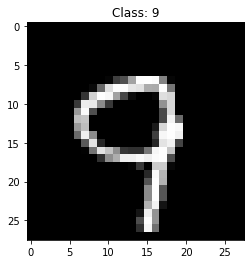

In [66]:
sample_img, img_class = dataset[np.random.randint(len(dataset))]

plt.imshow(sample_img, cmap='gray', vmin=0, vmax=255)
plt.title(f"Class: {img_class}")
plt.show()

In [69]:
def find_bbox(img):
    found_x = found_y = -1
    for i in range(28):
        for j in range(28):
            if img[i][j] != 0:
                if(found_y == -1):
                    found_y = i
                if(found_x == -1 or j < found_x):
                    found_x = j
    x_start, y_start = found_x, found_y
    found_x = found_y = -1

    for i in range(27, -1, -1):
        for j in range(27, -1, -1):
            if img[i][j] != 0:
                if(found_y == -1):
                    found_y = i
                if(found_x == -1 or j > found_x):
                    found_x = j
    
    return (x_start-1, y_start-1, found_x+1, found_y+1)

5 6 20 27


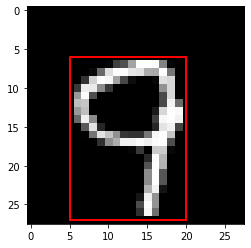

In [70]:
xs, ys, xe, ye = find_bbox(torchvision.transforms.PILToTensor()(sample_img)[0])
print(xs, ys, xe, ye)

fig, ax = plt.subplots()
ax.imshow(sample_img, cmap='gray', vmin=0, vmax=255)
rect = patches.Rectangle((xs, ys), xe-xs, ye-ys, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

In [44]:
torchvision.transforms.PILToTensor()(sample_img)[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [ ]:
class MnistNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.PILToTensor(),
            torchvision.transforms.ConvertImageDtype(torch.float32),
            torchvision.transforms.Normalize(mean=1, std=0.5),
        ])

        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, 10)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, img_in):

        transformed_img = self.transform(img_in).view(1,-1)
        out = self.linear1(transformed_img)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.softmax(out)

        return out


In [ ]:
model = MnistNN()
loss_fn = nn.CrossEntropyLoss()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

lr = 1e-4
optimizer = torch.optim.RMSProp(model.params, lr=lr, alpha=0.9)

EPOCH_NUM = 10

for epoch in EPOCH_NUM:
    for idx, (img, label) in train_dataloader:
        logits = model(img)
        loss = loss_fn(logits, label)

AttributeError: ignored